A template of the RL training, with H-network trained along side the PPO agent

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import sys

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707_downsampled_1min", "split")

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
# convert datetime objects to timezone-naive datetime objects
def convert_to_naive_datetimes_df(df):
    """Convert datetime objects in DataFrame to timezone-naive datetime objects"""
    df['datetime'] = df['datetime'].apply(lambda x: x.replace(tzinfo=None) if isinstance(x, datetime) else x)

    return df

def convert_to_naive_datetimes(segments):
    """Convert datetime objects in segments to timezone-naive datetime objects"""
    return [(start.replace(tzinfo=None), end.replace(tzinfo=None)) for start, end in segments]

In [6]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test') 
aggregate_load_segments_validation, aggregate_load_df_validation = load_split_data_from_folder(dataset_folder_path, 'val')

In [7]:
aggregate_load_segments_train, aggregate_load_df_train = convert_to_naive_datetimes(aggregate_load_segments_train), convert_to_naive_datetimes_df(aggregate_load_df_train)
aggregate_load_segments_test, aggregate_load_df_test = convert_to_naive_datetimes(aggregate_load_segments_test), convert_to_naive_datetimes_df(aggregate_load_df_test)
aggregate_load_segments_validation, aggregate_load_df_validation = convert_to_naive_datetimes(aggregate_load_segments_validation), convert_to_naive_datetimes_df(aggregate_load_df_validation)

In [8]:
aggregate_load_df_train

,datetime,aggregate,timestamp
0,2013-01-08 00:00:05,234.000000,1357603205
1,2013-01-08 00:01:05,230.407069,1357603265
2,2013-01-08 00:02:05,230.680121,1357603325
3,2013-01-08 00:03:05,231.607379,1357603385
4,2013-01-08 00:04:05,231.280688,1357603445
...,...,...,...
231546,2013-12-30 23:55:01,176.973052,1388447701
231547,2013-12-30 23:56:01,177.850890,1388447761
231548,2013-12-30 23:57:01,177.333811,1388447821
231549,2013-12-30 23:58:01,178.462801,1388447881


In [9]:
aggregate_load_segments_train

[(datetime.datetime(2013, 1, 8, 0, 0),
  datetime.datetime(2013, 1, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 9, 0, 0),
  datetime.datetime(2013, 1, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 10, 0, 0),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 27, 0, 0),
  datetime.datetime(2013, 2, 27, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 28, 0, 0),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 8, 0, 0),
  datetime.datetime(2013, 3, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 9, 0, 0),
  datetime.datetime(2013, 3, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 10, 0, 0),
  datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 28, 0, 0),
  datetime.datetime(2013, 3, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 29, 0, 0),
  datetime.datetime(2013, 3, 29, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 30, 0, 0),
  datetime.datetim

---

Experiment start

In [10]:
# initialize experiment folder to store related information/data for future analysis

rl_datetime = datetime.now()

experiment_folder = Path(
    "experiments", rl_datetime.strftime('%Y%m%d_%H%M%S')
)

if not experiment_folder.exists():
    experiment_folder.mkdir(parents=True)

Create data loader

In [11]:
sys.path.append(str(Path('rl_env')))
sys.path.append(str(Path('model', 'H_network')))

from rl_env.data_loader import SimpleSmartMeterDataLoader
from rl_env.training_mode import TrainingMode

sm_dl_train = SimpleSmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_train,
    aggregate_load_df=aggregate_load_df_train,
    registry_path=experiment_folder / "simple_episode_registry_train.json"
)

sm_dl_train.get_divided_segments_length()

[SimpleDataLoader] Generated 162 episodes (1 day each)


162

In [12]:
sm_dl_train.divided_segments[7]

array([datetime.datetime(2013, 3, 10, 0, 0),
       datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)], dtype=object)

In [13]:
# sample segment

sm_dl_train.get_aggregate_load_segment(13)

,timestamp,aggregate,datetime,segment_index,episode_content_id,episode_length_days
11231,1363996805,335.000000,2013-03-23 00:00:05,13,5af8f04ee4a2,1
11232,1363996865,317.206591,2013-03-23 00:01:05,13,5af8f04ee4a2,1
11233,1363996925,293.301546,2013-03-23 00:02:05,13,5af8f04ee4a2,1
11234,1363996985,276.229767,2013-03-23 00:03:05,13,5af8f04ee4a2,1
11235,1363997045,276.501419,2013-03-23 00:04:05,13,5af8f04ee4a2,1
...,...,...,...,...,...,...
12666,1364082905,173.758178,2013-03-23 23:55:05,13,5af8f04ee4a2,1
12667,1364082965,172.392595,2013-03-23 23:56:05,13,5af8f04ee4a2,1
12668,1364083025,174.270419,2013-03-23 23:57:05,13,5af8f04ee4a2,1
12669,1364083085,171.201633,2013-03-23 23:58:05,13,5af8f04ee4a2,1


In [14]:
# create dataloader for validation and test sets
sm_dl_validation = SimpleSmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_validation,
    aggregate_load_df=aggregate_load_df_validation,
    registry_path=experiment_folder / "simple_episode_registry_validation.json"
)

# sm_dl_test = SimpleSmartMeterDataLoader(
#     dataset_path=dataset_folder_path,
# )

[SimpleDataLoader] Generated 73 episodes (1 day each)


Create the environment

In [15]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
import sys

from model.H_network.h_network_rl_continuous_act import HNetworkRLModule
from model.H_network.h_network_arch import HNetworkType

h_network_rl_module = HNetworkRLModule(
    h_network_type=HNetworkType.H_NETWORK,
    device=DEVICE
)

In [17]:
REWARD_LAMBDA = 0.5  # lambda for the reward function

In [18]:
from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld

env_train = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_train,
    h_network_rl_module=h_network_rl_module,
    mode = TrainingMode.TRAIN,
    log_folder=experiment_folder / 'logs_train',
    reward_lambda=REWARD_LAMBDA,
    # render_mode="human",
    render_mode=None,
)

[2025-07-29 04:55:41:862] [SmartMeterWorld Train] Using data loader: SimpleSmartMeterDataLoader
[2025-07-29 04:55:41:862] [SmartMeterWorld Train] Curriculum enabled: False


In [19]:
h_network_rl_module.set_h_network(
    h_network_rl_module.initialize_h_network()
)
h_network_rl_module.initialize_h_network_training()

In [20]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env_train)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

[2025-07-29 04:55:42:574] [SmartMeterWorld Train] Resetting environment with episode 149. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}
[2025-07-29 04:55:42:578] [SmartMeterWorld Train] Resetting environment with episode 2. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-29 04:55:42:580] [SmartMeterWorld Train] Resetting environment with episode 110. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}
[2025-07-29 04:55:42:583] [SmartMeterWorld Train] Resetting environment with episode 2. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-29 04:55:42:585] [SmartMeterWorld Train] Resetting environment with episode 110. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00

/root/miniforge3/envs/smartmeter/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


In [21]:
obs, info = env_train.reset()
obs

[2025-07-29 04:55:42:743] [SmartMeterWorld Train] Resetting environment with episode 110. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}


{'aggregate_load': array([-0.4250123], dtype=float32),
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5 ,  0.  ,  0.25], dtype=float32)}

In [22]:
info

{'episode_index': 110,
 'current_step': 0,
 'datetime': '2013-09-26T00:00:00',
 'battery_soc (%)': 0.15000000596046448,
 'battery_soc (kWh)': 1.2000000476837158,
 'user_load (W)': 213.0,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [23]:
env_train.reset_render_window()

Also initiate a validation environment for time-to-time validation

In [24]:
# also initiate the validation environment

env_validation = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    mode=TrainingMode.VALIDATE, 
    log_folder=experiment_folder / 'logs_validation',
    reward_lambda=REWARD_LAMBDA,
    # render_mode="human",
    render_mode=None,
)

[2025-07-29 04:55:42:799] [SmartMeterWorld Validate] Using data loader: SimpleSmartMeterDataLoader
[2025-07-29 04:55:42:800] [SmartMeterWorld Validate] Curriculum enabled: False


In [25]:
obs, info = env_validation.reset()

obs

[2025-07-29 04:55:42:825] [SmartMeterWorld Validate] Resetting environment with episode 42. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-08-12 00:00:03'), Timestamp('2013-08-12 23:59:03'))}


{'aggregate_load': array([-0.29699537], dtype=float32),
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5       , -0.5       ,  0.16666667], dtype=float32)}

In [26]:
info

{'episode_index': 42,
 'current_step': 0,
 'datetime': '2013-08-12T00:00:03',
 'battery_soc (%)': 0.15000000596046448,
 'battery_soc (kWh)': 1.2000000476837158,
 'user_load (W)': 157.0,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [27]:
# callbacks for training
from rl_env.hrl_env_callbacks import TrainHNetworkEveryNEpisodes, SaveCheckpointEveryNEpisodes, ValidateEveryNEpisodes

2025-07-29 04:55:43.066521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 04:55:43.075156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753761343.083720 1346304 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753761343.086399 1346304 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753761343.093463 1346304 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [28]:
# define a custom logger

from stable_baselines3.common.logger import configure

# all logs (json files, tensorboard) will be saved in the specified foler
logger = configure(str(experiment_folder / "logs_train"), ["stdout", "json", "tensorboard"])

Logging to experiments/20250729_045540/logs_train


In [29]:
# initialize a PPO agent
from stable_baselines3 import PPO

rl_datetime = datetime.now()

rl_model = PPO(
    "MultiInputPolicy", 
    env_train, 
    verbose=2,
)

rl_model.set_logger(logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Show the model architecture of the policy

In [30]:
rl_model.policy.mlp_extractor.value_net

Sequential(
  (0): Linear(in_features=5, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
)

In [31]:
rl_model.policy.value_net

Linear(in_features=64, out_features=1, bias=True)

In [32]:
rl_model.policy.mlp_extractor.policy_net

Sequential(
  (0): Linear(in_features=5, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
)

In [33]:
rl_model.policy.action_net

Linear(in_features=64, out_features=1, bias=True)

The output of the action_net is the mean for the (policy) distribution.

The (policy) distribution is a Gaussian, with variable mean and log_std.  
See: 
https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/policies.py#L597  
Then
https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/distributions.py#L150  
Then
https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/policies.py#L694

They are updated in PPO.train() method  
https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/ppo/ppo.py#L275

Training

In [34]:
env_train.save_env_config(env_train.log_folder.parent)

[2025-07-29 04:55:44:212] [SmartMeterWorld Train] Environment config saved to experiments/20250729_045540/env_config.json


In [35]:
every_n_episodes = 5
sweep_every_n_episodes = 5 * 10  # every 50 episodes

rl_model.learn(
    total_timesteps=24 * 60 * 120,  # 600 episodes, each episode is 24 hours (with 1 min sample frequency)
    progress_bar=False,
    tb_log_name="PPO_SmartMeterWorld",
    callback=[
        TrainHNetworkEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module),
        SaveCheckpointEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module, save_folder=experiment_folder / "checkpoints"),
        ValidateEveryNEpisodes(every_n_episodes=every_n_episodes * 5, sweep_every_n_episodes=sweep_every_n_episodes, validation_log_folder=experiment_folder / "logs_validation", validation_env=env_validation, h_network_rl_module=h_network_rl_module, best_model_save_path=experiment_folder / "best_model")
    ]
)

# save the training results
print_log("Saving training results...")

env_train.save_episodes_rewards(experiment_folder / "logs_train")
h_network_rl_module.save_train_loss_list(experiment_folder / "logs_train" / "h_network_train_loss_list.json")

# save both RL modeel and H-network at the end of training
rl_model_path = experiment_folder / f"rl_model.zip"
h_network_path = experiment_folder / f"h_network2.pth" if h_network_rl_module.h_network_type == HNetworkType.H_NETWORK2 else experiment_folder / f"h_network.pth"

rl_model.save(rl_model_path)
h_network_rl_module.save_h_network(h_network_path)

[2025-07-29 04:55:44:247] [SmartMeterWorld Train] Resetting environment with episode 96. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}
[2025-07-29 04:55:50:646] Episode 0001 info saved to experiments/20250729_045540/logs_train/episode_info/episode_0001_info.json
[2025-07-29 04:55:50:647] Episode content ID: 43ad0a675bbd, Length: 1 day(s)
[2025-07-29 04:55:50:651] Episode 0001 DataFrame saved to experiments/20250729_045540/logs_train/episodes_df/episode_0001.pkl
[2025-07-29 04:55:50:651] [SmartMeterWorld Train] Episode finished. Sum of rewards: 37.608188858189926. Mean of rewards: 0.02613494708699786. Std of rewards: 0.02915998162552646
[2025-07-29 04:55:50:655] [SmartMeterWorld Train] Resetting environment with episode 8. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}
---------------------------------
| rollout/           |          |
|    ep_

KeyboardInterrupt: 

Read the logged .json file and open it as a Dataframe

In [ ]:
from stable_baselines3.common.logger import read_json

# Read the logged .json file and open it as a Dataframe
log_file_path = experiment_folder / "logs_train" / "progress.json"
if log_file_path.exists():
    log_data = read_json(log_file_path)

log_data

,time/iterations,rollout/ep_rew_mean,rollout/ep_len_mean,time/fps,time/time_elapsed,time/total_timesteps,train/learning_rate,train/entropy_loss,train/policy_gradient_loss,train/value_loss,train/approx_kl,train/clip_fraction,train/loss,train/explained_variance,train/std,train/n_updates,train/clip_range
0,1,27.836703,1439.000000,196,10,2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,35.647487,1439.000000,172,23,4096,0.0003,-1.421744,-0.000692,0.142733,0.002319,0.007129,0.061496,0.122342,1.002843,10.0,0.2
2,3,37.016291,1439.000000,169,36,6144,0.0003,-1.418326,-0.002038,0.142876,0.004508,0.017041,0.074967,0.044340,0.996287,20.0,0.2
3,4,53.464151,1439.000000,162,50,8192,0.0003,-1.413454,-0.000513,0.259790,0.003059,0.006348,0.064745,0.368085,0.993549,30.0,0.2
4,5,50.615886,1439.000000,163,62,10240,0.0003,-1.406704,-0.002037,0.352293,0.003224,0.019141,0.125439,0.527543,0.980388,40.0,0.2
5,6,52.517471,1439.000000,160,76,12288,0.0003,-1.401415,-0.004738,0.174548,0.006176,0.067334,0.099028,0.727950,0.982648,50.0,0.2
6,7,50.563040,1439.000000,162,88,14336,0.0003,-1.407412,-0.000101,0.260995,0.001507,0.000879,0.120593,0.729128,0.992891,60.0,0.2
7,8,55.800491,1439.000000,163,100,16384,0.0003,-1.414498,-0.001151,0.093438,0.003414,0.016406,0.033718,0.949526,0.992724,70.0,0.2
8,9,55.457692,1439.000000,161,114,18432,0.0003,-1.414113,-0.000016,0.751234,0.001104,0.001025,0.316701,0.068033,0.997127,80.0,0.2
9,10,60.926195,1439.000000,162,126,20480,0.0003,-1.412592,-0.001191,0.152249,0.002865,0.017529,0.074514,0.912167,0.988702,90.0,0.2


End of Training

---

Create a validation environment

and put the policy into the validation env

In [56]:
import sys
sys.path.append(str(Path('rl_env')))
from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld

env_valid = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    render_mode="human",
)

[2025-07-18 03:32:05:355] [SmartMeterWorld] Render mode set to 'human'. Render server at 127.0.0.1:50007. render_connected: True. render_client_socket: <socket.socket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 43564), raddr=('127.0.0.1', 50007)>


In [57]:
env_valid.reset_render_window()

In [58]:
rl_model.set_env(env_valid)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [59]:
obs, info = env_valid.reset(episode_idx=67)
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_valid.step(action)
        print_log(f"Step: {env_valid.episode.get_current_step()}, Action: {action}, Reward: {reward}")
        env_valid.render()

[2025-07-18 03:32:23:985] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}
[2025-07-18 03:32:23:998] Step: 1, Action: [1.], Reward: 0.18053002394040427
[2025-07-18 03:32:24:009] Step: 2, Action: [1.], Reward: 0.17914232350190482
[2025-07-18 03:32:24:017] Step: 3, Action: [1.], Reward: 0.17833086586793265
[2025-07-18 03:32:24:023] Step: 4, Action: [1.], Reward: 0.17816708720525107
[2025-07-18 03:32:24:030] Step: 5, Action: [1.], Reward: 0.17814989126523337
[2025-07-18 03:32:24:036] Step: 6, Action: [1.], Reward: 0.17816172278722128
[2025-07-18 03:32:24:042] Step: 7, Action: [1.], Reward: 0.17818316555817923
[2025-07-18 03:32:24:047] Step: 8, Action: [1.], Reward: 0.17821264005502066
[2025-07-18 03:32:24:057] Step: 9, Action: [1.], Reward: 0.17823903001149496
[2025-07-18 03:32:24:062] Step: 10, Action: [1.], Reward: 0.17826284206708273
[2025-07-18 03:32:24:068

In [61]:
env_valid.episode.df

,timestamp,aggregate,datetime,grid_load,battery_soc,aggregate_std
95537,1386547205,161.000000,2013-12-09 00:00:05,4161.0,0.0,-0.476119
95538,1386547265,158.267579,2013-12-09 00:01:05,4158.267579,0.008333,-0.483984
95539,1386547325,158.744906,2013-12-09 00:02:05,4158.744906,0.016667,-0.482610
95540,1386547385,158.232859,2013-12-09 00:03:05,4158.232859,0.025,-0.484084
95541,1386547445,158.823906,2013-12-09 00:04:05,4158.823906,0.033333,-0.482383
...,...,...,...,...,...,...
96972,1386633305,338.808387,2013-12-09 23:55:05,0.0,0.790642,0.035682
96973,1386633365,336.695011,2013-12-09 23:56:05,0.0,0.789936,0.029599
96974,1386633425,334.400496,2013-12-09 23:57:05,0.0,0.789235,0.022995
96975,1386633485,336.472574,2013-12-09 23:58:05,0.0,0.788538,0.028959


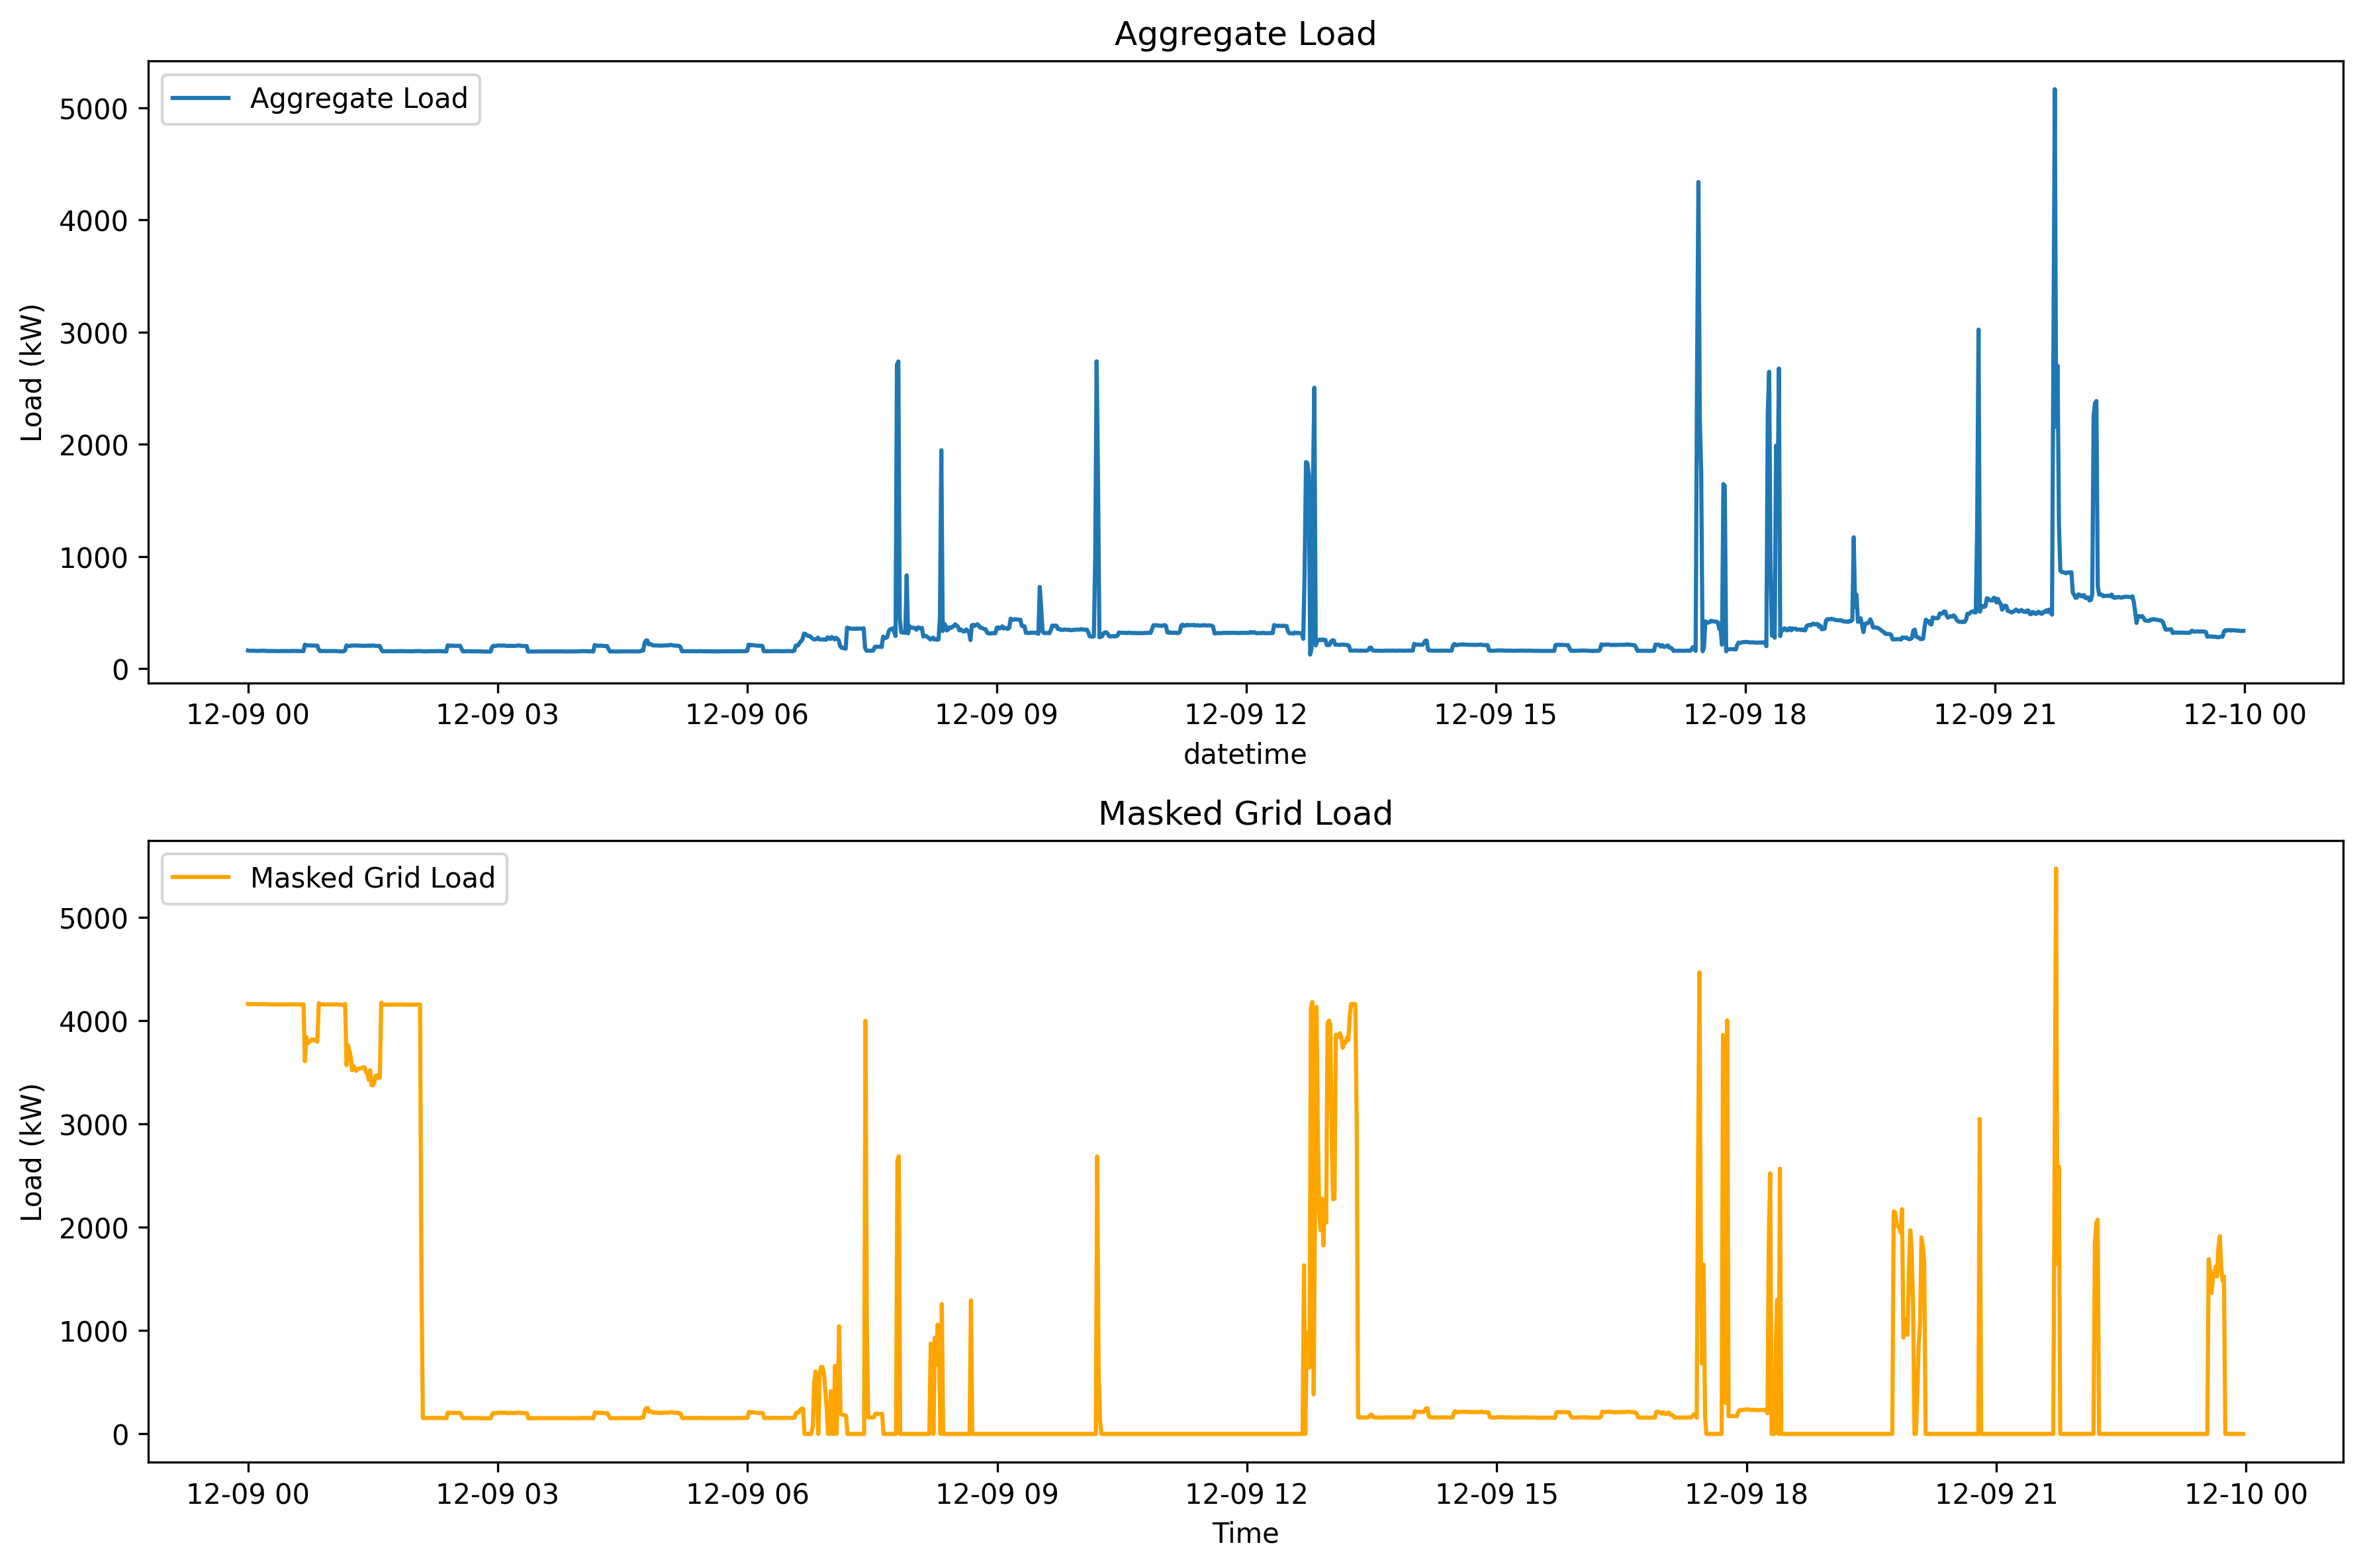

In [ ]:
# create a plot with two subplots
# on top plot the aggregate load
# on bottom plot the masked grid load
# to better visualize the difference between the two

import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=300)
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['aggregate'], ax=ax1, label='Aggregate Load')
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['grid_load'], ax=ax2, label='Masked Grid Load', color='orange')

ax1.set_title('Aggregate Load')
ax1.set_ylabel('Load (kW)')
ax1.legend()
ax2.set_title('Masked Grid Load')
ax2.set_xlabel('Time')
ax2.set_ylabel('Load (kW)')
ax2.legend()
plt.tight_layout()
plt.show()

In [60]:
# save the graph

env_valid.save_graph(
    {"fname": str(experiment_folder / f"graph_valid_index_{env_valid.selected_idx}.png"),
     "dpi": 300}
)

In [55]:
env_valid.close()

[2025-07-18 03:31:54:177] [SmartMeterWorld] Environment closed.


---

In [ ]:
# load the model & environment
import sys
sys.path.append(str(Path('rl_env')))

from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld
from stable_baselines3 import PPO
from model.H_network.h_network_arch import HNetworkType

env_test = SmartMeterWorld(
    sm_dl_test,
    h_model_type=HNetworkType.H_NETWORK,
    render_mode="human",
)

env_test.set_h_network(h_network)
env_test.set_h_network_stdscaler(h_network_stdscaler)

rl_model_path = Path("rl_model", "PPO", f"{datetime(2025,7,12,18,25,2).strftime('%Y%m%d_%H%M%S')}", "rl_model.zip")
rl_model_loaded = PPO.load(rl_model_path, env=env_test)

In [ ]:
obs, info = env_test.reset(43)

In [ ]:
info

In [ ]:
env_test.reset_render_window()

In [ ]:
env_test.episode.df

In [ ]:
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model_loaded.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_test.step(action)
        print_log(f"Step: {env_test.episode.get_current_step()}, Action: {action}, Reward: {reward}, Info: {info}")
        env_test.render()

In [ ]:
env_test.save_graph(
    str(Path("rl_model", "PPO", f"{rl_datetime.strftime('%Y%m%d_%H%M%S')}", "graph_test.png"))
)

In [ ]:
env_test.close()